## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [46]:
import pandas as pd
import numpy as np

In [47]:
df_train = pd.read_csv('readonly/train.csv', sep=",", encoding='mac_roman',low_memory=False)
df_test = pd.read_csv('readonly/test.csv')

Primeiramente precisamos retirar as colunas que estão presentes somente nos dados para treinamento e não nos dados para teste, já que essas informação não podem ser usadas para a generalização do modelo.

In [48]:
target = df_train['compliance']
df_train = df_train[df_test.columns]
df_train['compliance'] = target

In [49]:
df_train = df_train.dropna(subset=['compliance'])

Abaixo temos todas as colunas que serão retiradas dos dados para treinar o modelo. Algumas não oferecem nenhuma informação preditiva, como 'inspector_name' e 'violator_name' por exemplo, pois são apenas os nomes das pessoa. Outras são constantes, como 'admin_fee', 'state_fee', 'late_fee' e 'clean_up_cost'. Por fim, a variável 'agency_name' oferece algum poder preditivo, no entanto essas agências não se mantém as mesmas com o tempo, o que é possível ver pela preseça de agências diferentes nos dados de teste, por isso essa coluna também é retirada.

In [50]:
drop = ['inspector_name','violator_name','violation_street_number', 'violation_street_name', 
        'violation_zip_code','mailing_address_str_number', 'mailing_address_str_name', 
        'city', 'state', 'zip_code', 'non_us_str_code', 'country','ticket_issued_date','hearing_date',
        'violation_description','violation_code','admin_fee','state_fee','late_fee','clean_up_cost',
        'grafitti_status','agency_name','disposition']

In [51]:
features = [col for col in df_train.columns if col not in drop]
features_test = [col for col in df_test.columns if col not in drop]

In [52]:
df_test = df_test[features_test]
df_test = df_test.set_index('ticket_id')

In [53]:
df_train = df_train[features]

Com as features definidas, podes separar os dados de treino em treino e teste para validar o modelo antes de submeter para o teste final com os dados de teste, para os quais não temos a classificação.

In [54]:
from sklearn.model_selection import train_test_split

X = df_train[['fine_amount', 'discount_amount', 'judgment_amount']]
y = df_train['compliance']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [55]:
y_train.value_counts()

0.0    111205
1.0      8705
Name: compliance, dtype: int64

Vemos acima que a classes para classificação são bastante desbalanceadas, o que justifica a utilização da métrica roc-auc no lugar da accuracy, que teria um valor alto mesmo para um classificador que apenas classifica como a classe mais frequente (dummie classifier).

Usamos como modelo a Regressão Logística, devido a simplicidade dos dados que temos (apenas três features) e a quantidade de dados (A Regressão Logística não consome muito tempo).

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

lr = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)

y_score_lr = lr.predict_proba(X_train)
fpr_lr, tpr_lr, _ = roc_curve(y_train, y_score_lr[:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
print('train set roc-auc {:.5f}'.format(roc_auc_lr))

y_score_lr = lr.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr[:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
print('test set roc-auc {:.5f}'.format(roc_auc_lr))

train set roc-auc 0.75280
test set roc-auc 0.75263


Podemos ver que esse modelo com as features escolhidas funciona muito bem, tanto nos dados de treino quanto nos de teste, o que evidencia a eficâcia do modelo em generalizar para novos dados. 

Abaixo vemos um plor da curva ROC, acima da curva de um modelo aleatório (pontilhada), mostrando que o modelo funciona bem.

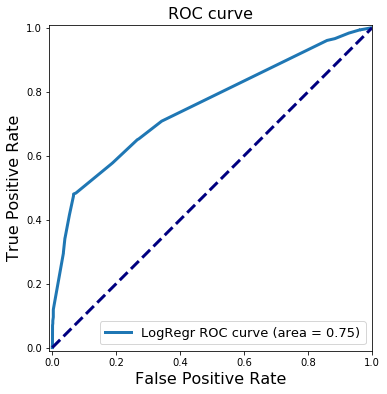

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

Abaixo definimos uma função que treina o mesmo modelo, mas agora utilizando todos os dados de treino, e aplica esse modelo nos dados de teste retornando a probabilidade de que cada multado pague a sua multa dentro do tempo estimado. A avaliação dessas predições foi muito parecida com as obtidas acima, com uma auc um pouco acima de 0.75, resultando em nota máxima nessa avaliação.

In [60]:
import pandas as pd
import numpy as np

def blight_model():
    
    # Your code here
    df_train = pd.read_csv('readonly/train.csv', sep=",", encoding='mac_roman',low_memory=False)
    df_test = pd.read_csv('readonly/test.csv')
    
    target = df_train['compliance']
    df_train = df_train[df_test.columns]
    df_train['compliance'] = target
    df_train = df_train.dropna(subset=['compliance'])
    
    drop = ['inspector_name','violator_name','violation_street_number', 'violation_street_name', 
            'violation_zip_code','mailing_address_str_number', 'mailing_address_str_name', 
            'city', 'state', 'zip_code', 'non_us_str_code', 'country','ticket_issued_date','hearing_date',
            'violation_description','violation_code','admin_fee','state_fee','late_fee','clean_up_cost',
            'grafitti_status','agency_name','disposition']
    features = [col for col in df_train.columns if col not in drop]
    features_test = [col for col in df_test.columns if col not in drop]
    
    df_test = df_test[features_test]
    df_test = df_test.set_index('ticket_id')
    
    df_train = df_train[features]
    df_train = df_train.set_index('ticket_id')
    
    from sklearn.model_selection import train_test_split

    X = df_train[['fine_amount', 'discount_amount', 'judgment_amount']]
    y = df_train['compliance']
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc

    lr = LogisticRegression(random_state=0).fit(X, y)
    
    y_test_prob = lr.predict_proba(df_test)
    df_test[''] = y_test_prob[:,1]
    
    return df_test['']# Your answer here

In [61]:
blight_model()

/home/diego/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/diego/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


ticket_id
284932    5.791636e-02
285362    5.031950e-03
285361    7.749581e-02
285338    5.791636e-02
285346    7.749581e-02
285345    5.791636e-02
285347    8.941856e-02
285342    1.968266e-01
285530    5.031950e-03
284989    2.352760e-02
285344    8.941856e-02
285343    5.031950e-03
285340    5.031950e-03
285341    8.941856e-02
285349    7.749581e-02
285348    5.791636e-02
284991    2.352760e-02
285532    2.352760e-02
285406    2.352760e-02
285001    2.352760e-02
285006    5.031950e-03
285405    5.031950e-03
285337    2.352760e-02
285496    8.941856e-02
285497    5.791636e-02
285378    5.031950e-03
285589    2.352760e-02
285585    5.791636e-02
285501    7.749581e-02
285581    5.031950e-03
              ...     
376367    1.091829e-02
376366    4.996352e-02
376362    4.996352e-02
376363    5.791636e-02
376365    1.091829e-02
376364    4.996352e-02
376228    4.996352e-02
376265    4.996352e-02
376286    2.285267e-01
376320    4.996352e-02
376314    4.996352e-02
376327    2.285267e-01
3